# COMP47670 Assignment 2

Student: Sipos Lucas George

Student ID: 24292215

---

## Overview: 

In this assignment we work with the employee dataset from `employee.csv`, and after doing some data characterisation and preprocessing, data analysis, and classification and evaluation, we want to see if we predict whether an employee will leave or stay based on various features like  demographics and job characteristics.

In [594]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Task 1: Data Characterisation and Preprocessing

In this part, we will load the dataset `employee.csv` perform an initial characterisation of the dataset to explore its structure and  to identify any data quality issues and apply appropriate preprocessing steps.


In [595]:
# loading the dataset
data = pd.read_csv('employees.csv', index_col=0)
# check the number of rows and columns
print(f"Dataset consists of {data.shape[0]} rows and {data.shape[1]} columns")
data.head()

Dataset consists of 1365 rows and 13 columns


,department,job_level,age,salary,company_years,career_years,hiring_source,education_level,recently_promoted,distance,work_from_home,travel_frequently,leave
employee_id,,,,,,,,,,,,,
EMP0310,IT,Mid,37,105129.0,10,10.0,Agency,Undergrad Degree,True,3,False,Yes,False
EMP1273,Finance,Junior,61,31902.0,1,13.0,Direct,Undergrad Degree,True,39,False,No,False
EMP0391,Sales,Junior,43,29722.0,9,13.0,Referral,NaN,False,14,True,No,False
EMP1372,Finance,Junior,29,33196.0,1,1.0,Direct,Undergrad Degree,False,9,True,Yes,True
EMP1208,Finance,Junior,29,32885.0,1,6.0,Agency,Undergrad Degree,False,3,False,Yes,True


### Initial Inspection and Quality Assessment

Look over the data and see if there are any mixed data types, missing values, duplicates or inconsistent data.

In [596]:
print(f"Dataset has {"all IDs unique" if data.index.unique().size == data.index.size else "duplicate IDs"} in 'employee_id' column")

Dataset has all IDs unique in 'employee_id' column


In [597]:
data.dtypes

department            object
job_level             object
age                    int64
salary               float64
company_years          int64
career_years         float64
hiring_source         object
education_level       object
recently_promoted       bool
distance               int64
work_from_home        object
travel_frequently     object
leave                   bool
dtype: object

Seems like `career_years` and `company_years` should be the same type and, after looking into the dataset, `work_from_home` should be a boolean.

In [598]:
# find duplicates
print(f"There are {data.duplicated().sum()} duplicate values")

There are 0 duplicate values


No duplicates were found.

In [599]:
# how many missing values per column?
null_values = data.isnull().sum()
# print only columns with missing values
null_values[null_values > 0]

career_years       54
education_level    40
work_from_home     32
dtype: int64

From the data above, we can tell that the following columns have null values:
- `career_years` (54 null values)
- `education_level` (40 null values)
- `work_from_home` (32 null values)

In [600]:
# check for irregular cardinality
for col in data.columns:
    print(col, "--", data.groupby(col).sum(numeric_only=True).index.values)

department -- ['Finance' 'HR' 'IT' 'Sales']
job_level -- ['Junior' 'Lead' 'Mid' 'Senior']
age -- [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
salary -- [ 11640.  12122.  12830. ... 243617. 244375. 244622.]
company_years -- [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 28 29 30 31 32 34]
career_years -- [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 36. 37.
 38. 39.]
hiring_source -- ['Agency' 'Direct' 'Direct Hire' 'Referral']
education_level -- ['MSc' 'Masters' 'PhD' 'Secondary' 'UG Degree' 'Undergrad Degree']
recently_promoted -- [False  True]
distance -- [  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  58  

Now by checking the irregular cardinality in the dataset we found that:
- `company_years` has negative values
- `hiring source` has 2 terms which conclude the same "Direct" - "Direct Hire"
- `education_level` has inconsistent values "MSc" - "Masters" and "UG Degree" - "Undergrad Degree", and the problem is that the level are mixed up, we should keep the Ireland 10-level framework
- `travel_frequently` has inconsistent values "N" - "No" and "Y" - "Yes"

### Data Cleaning and Preparation

We apply any preprocessing steps to clean the data.

For the moment we will only change the `company_years` column type to float.

In [601]:
# change to type float
data["company_years"] = data["company_years"].astype(float)
print(f"Column `company_years` is of the type {data["company_years"].dtypes}")

Column `company_years` is of the type float64


For the moment we will only add the missing values for the `career_years` and `education_level` columns.

In [602]:
data["career_years"] = data["career_years"].fillna(data["company_years"])
print(f"There are {data["career_years"].isnull().sum()} missing values in career years.")

There are 0 missing values in career years.


In [603]:
data["education_level"] = data["education_level"].fillna("No Education")
print(f"There are {data["education_level"].isnull().sum()} missing values in education level.")

There are 0 missing values in education level.


Now, we will modify the irregular values for columns that require such adjustments.

In [604]:
data["company_years"] = data["company_years"].replace(-1, 0)
print("company_years", "--", data.groupby("company_years").sum(numeric_only=True).index.values)

company_years -- [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 28. 29. 30. 31. 32. 34.]


In [605]:
data["hiring_source"] = data["hiring_source"].replace("Direct Hire", "Direct")
print("hiring_source", "--", data.groupby("hiring_source").sum(numeric_only=True).index.values)

hiring_source -- ['Agency' 'Direct' 'Referral']


In [606]:
data["travel_frequently"] = data["travel_frequently"].replace("N", "No")
data["travel_frequently"] = data["travel_frequently"].replace("Y", "Yes")
print("travel_frequently", "--", data.groupby("travel_frequently").sum(numeric_only=True).index.values)

travel_frequently -- ['No' 'Yes']


In [607]:
data["education_level"] = data["education_level"].replace("MSc", "Masters Degree")
data["education_level"] = data["education_level"].replace("Masters", "Masters Degree")
data["education_level"] = data["education_level"].replace("PhD", "Doctoral Degree")
data["education_level"] = data["education_level"].replace("Secondary", "Secondary School Degree")
data["education_level"] = data["education_level"].replace("UG Degree", "Bachelors Degree")
data["education_level"] = data["education_level"].replace("Undergrad Degree", "Bachelors Degree")
print("education_level", "--", data.groupby("education_level").sum(numeric_only=True).index.values)

education_level -- ['Bachelors Degree' 'Doctoral Degree' 'Masters Degree' 'No Education'
 'Secondary School Degree']


For the `work_from_home` column I will use Random Forest Classifier to predict if the individual is working from home or not, and after that change the column type to `bool`.

In [608]:
# make a copy of dataframe without employee_id column
data_copy = data.copy()
# encode categorical variables
data_copy = pd.get_dummies(data_copy, columns=["department", "job_level", "hiring_source", "education_level", "travel_frequently"])

# split data into data that needs to be split (test/train) and missing values to predict
X = data_copy[data_copy["work_from_home"].notna()].drop("work_from_home", axis=1)
y = data_copy[data_copy["work_from_home"].notna()]["work_from_home"].astype(bool)
X_missing = data_copy[data_copy["work_from_home"].isna()].drop("work_from_home", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

model = RandomForestClassifier(random_state=42)
# train the classifier
model.fit(X_train, y_train)
# get some statistics about its performance
y_dash = model.predict(X_test)
print("Model accuracy:", accuracy_score(y_test, y_dash))
print("Report:\n", classification_report(y_test, y_dash)[:162])

Model accuracy: 0.6337078651685393
Report:
               precision    recall  f1-score   support

       False       0.66      0.88      0.75       280
        True       0.51      0.21      0.30       165


We can see that the accuracy is not the best, but we have to roll with it. Maybe it's better that we have unbalanced data, because usually the remote work is not so popular.

In [609]:
# refit model as to include all the data for training
model.fit(X, y)
# make predictions for missing values
predicted_values = model.predict(X_missing)
print("Predicted values:", str(Counter(predicted_values))[9:-2].replace(":", " ="))

# fill missing values in the original dataset
data.loc[data["work_from_home"].isna(), "work_from_home"] = predicted_values

# check the updated dataset
print(f"There are {data["work_from_home"].isnull().sum()} missing values in work_from_home.")

Predicted values: False = 28, True = 4
There are 0 missing values in work_from_home.


In [610]:
# change to type bool
data["work_from_home"] = data["work_from_home"].astype(bool)
print(f"Column `work_from_home` is of the type {data["work_from_home"].dtypes}")

Column `work_from_home` is of the type bool


---

## Task 2: Data Analysis

In this part, we will create 3 type of plots: 
- one plot to determine whether the distribution of the target feature `leave` in the dataset is evenly balanced
- one to analyse how the values of the target feature `leave` relate to each of the _categorical_ features in the data
- one to analyse how the values of the target feature `leave` relate to each of the _numeric_ features in the data

In [611]:
COLORS = ["red", "springgreen"]

### Is the dataset evenly balanced?

We could use many methods to find out if the data is evenly balanced such as `countplot` or `histogram` or `piechart`, but in this example I will use the simplest (`countplot`) because there are only 2 values that determine our distribution.

The exact distribution of 'leave' is: False = 986, True = 379


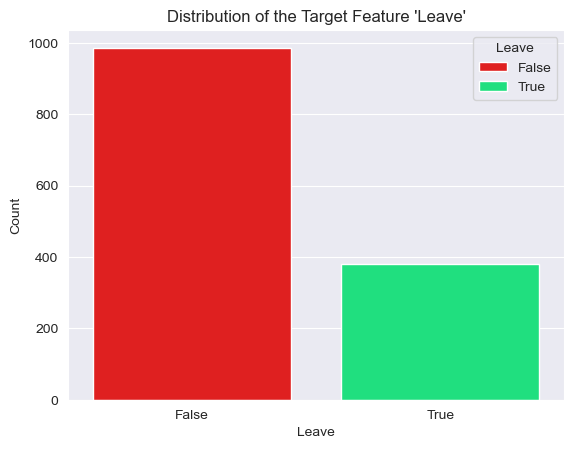

In [612]:
t_f = Counter(data["leave"])
print(f"The exact distribution of 'leave' is: False = {t_f[False]}, True = {t_f[True]}")
sns.countplot(data=data, x='leave', palette=COLORS, hue="leave")
plt.title("Distribution of the Target Feature 'Leave'")
plt.xlabel("Leave")
plt.ylabel("Count")
plt.legend(title="Leave", loc="upper right")
plt.show()

From the plot we can see that `False` is at least double in size compared to `True`. Meaning the data is unbalanced, and we have more people staying than leaving.

### "Leave" vs Categorical Features

For each _categorical_ feature, we will examine how `leave` relates to its values.

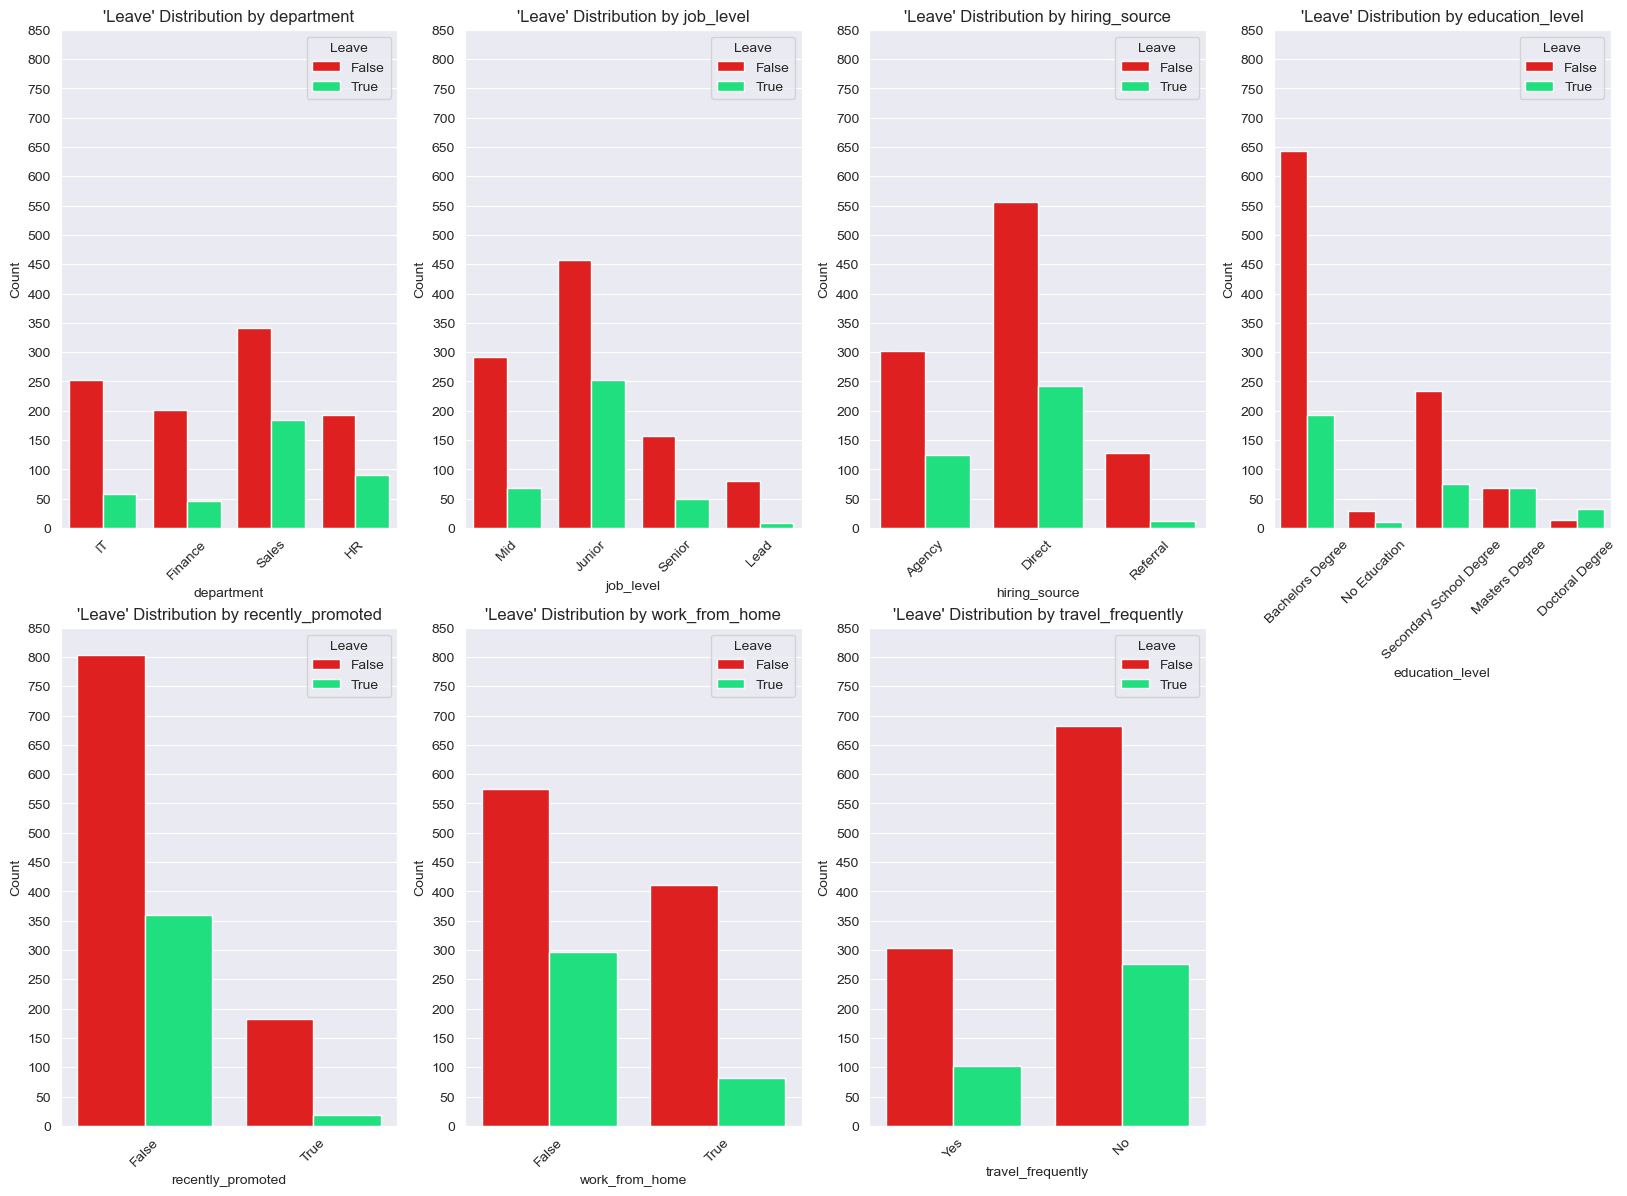

In [613]:
# select only the features with data types: object and bool (a.k.a. categorical features in this case)
categorical_features = data.select_dtypes(include=["object", "bool"]).columns[:-1]
plt.figure(figsize=(20, 22))

for i, feature in enumerate(categorical_features, start=1):
    ax = plt.subplot(3, 4, i)
    sns.countplot(data=data, x=feature, ax=ax, palette=COLORS, hue="leave")
    plt.title(f"'Leave' Distribution by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title="Leave", loc="upper right")
    plt.xticks(rotation=45)
    plt.yticks([i for i in range(0, 851, 50)])
plt.show()

I'll give my opinion on every feature plotted above, 1 - more of an analytics point of view and 2 - information gain:
1. By `department`
    1. For _Sales_ and _HR_ I would say it is more common to leave than the other 2 just because the number of leaving individuals are approximately half of the ones staying, which is a big deal, so people from _IT_ and _Finance_ are more loyal to their company.
    2. The information gain is not very significant given the fact that it's relatively unclear for the _Sales_ and _HR_ categories.
2. By `job_level`
    1. As expected the _Junior_ role individuals tend to leave more than the other roles maybe because for the other ones you need a bigger commitment and also hard to get into (_Lead_). Also, we can see the hierarchy of the job level, meaning as the role gets more important, the number of people with that role is significantly lower. 
    2. The information gain maybe is a little bit more than the previous one, but still not very good because there are a good amount of categories and the proportions are not good.
3. By `hiring_source`
    1. We can see that _Referral_ has the lowest leaving rate, even tho the size of that data isn't that big, but my point is that, it is logical to be like that because when you look for referral or already have one, you tend to stay at that company, not like _Agency_ or _Direct_ which have a bigger tendency of leaving. We can also see that most of the people got into the company through direct hiring.
    2. The information gain again may be better than the previous ones because now we have less categories and the _Referral_ one is a good one, but still after that we need to deal with _Direct_ and _Agency_, not the best not the worse.
4. By `education_level`
    1. Something really interesting is that we found the first data that has more leaving individuals than staying (for the _Doctoral Degree_ category) and also after looking through the exact count of _Masters Degree_ category against leave, is a 1:1 relation, meaning for every staying employee there is a leaving one. The individuals that leave the most from these categories are the ones that have from _Bachelors Degree_ category, and they are the most to join the company. We can also see that they are not accepting many people with _No Eduction_, and they are not looking for people with _Doctoral Degree_ (or not many people with _Doctoral Degree_ are looking for them). 
    2. The information gain is not that good, because we have a lot of categories and _Masters Degree_ is a 50/50 choice.
5. By `recently_promoted`
    1. We can see the individuals that received a promotion are not likely to leave the company, but the ones that didn't get one recently are more likely to leave, which was expected given the fact that they don't feel like advancing with the company.
    2. The information gain is significant because we only have 2 categories to choose from and the _True_ category it's very good for the reason that there is a small amount of people that want to leave and the other category is not as solid as the previous one, but not that bad.
6. By `work_from_home`
    1. Another expected behaviour is this one, because we all know that working from home is something that everyone desires but not everyone gets. And again not working from home is a major factor for leaving the company.
    2. The information gain is not that bad given that for _True_ category we have a small amount of people leaving and the _False_ category is pretty weak at giving information.
7. By `travel_frequently`
    1. As expected there are more individuals leaving from _No_ category, but I think that's the case because there aren't many roles that require to travel frequently. 
    2. The information gain is not the best not the worse, because the _Yes_ category has close to a small group of people leaving the company and the other one is not very good at giving information.

Overall I would say that most of them don't give us a lot of information about the employee leaving or not, but one that stands out by being able to give us some information is `recently_promoted`, because there are only 2 factors and the _True_ category is very helpful by not having a lot of people leaving and the _False_ category is not as helpful, but gives us a perspective that a lot of people would stay.

### "Leave" vs. Numeric Features

For each _numerical_ feature, we will examine how `leave` relates to its values.

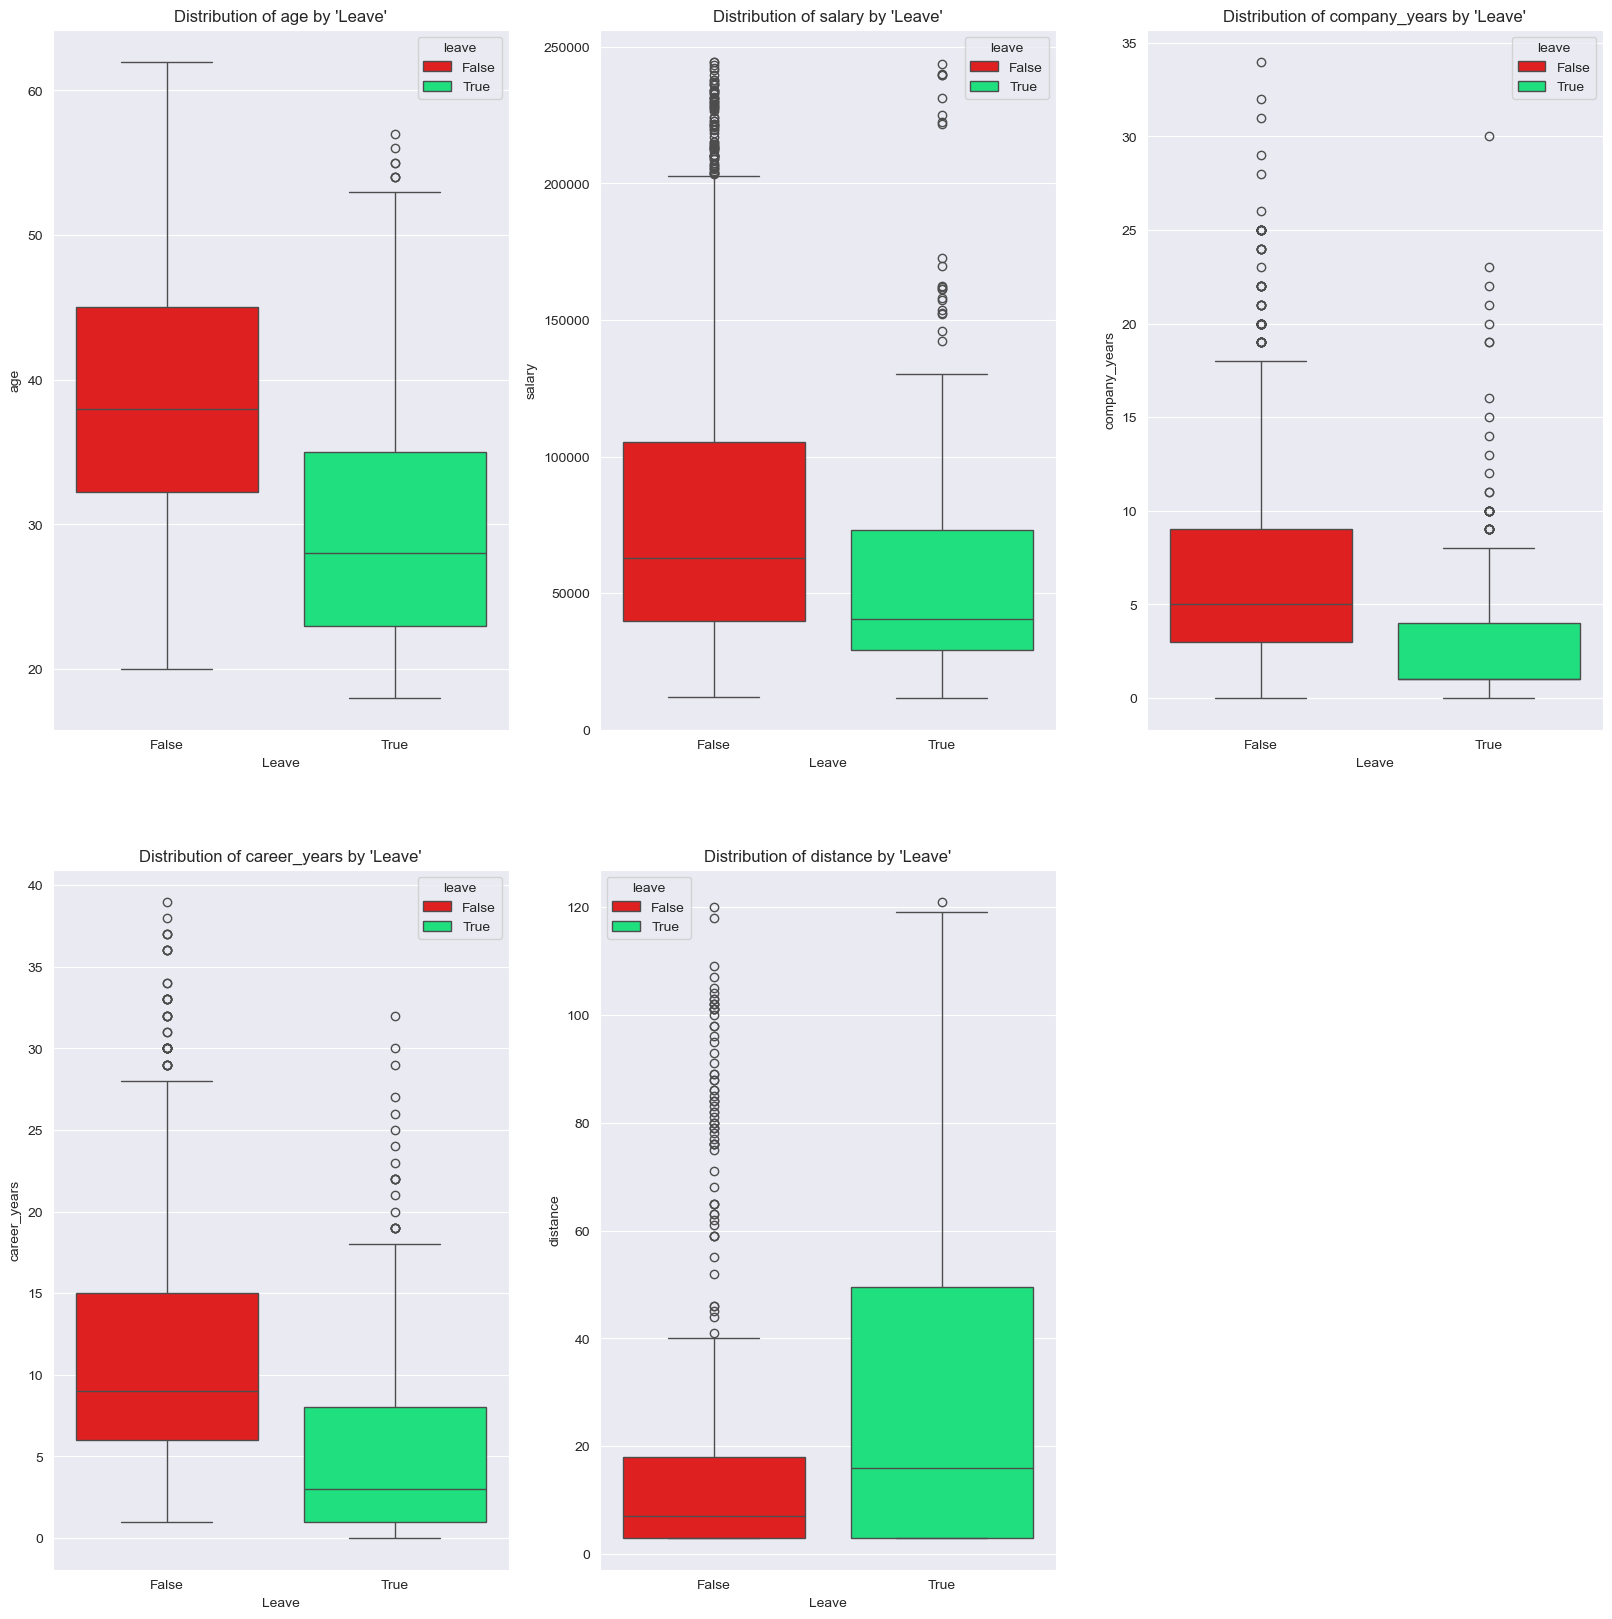

In [614]:
# select only the features with data types: float and int (a.k.a. numeric features in this case)
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(20, 20))

for i, feature in enumerate(numeric_features, start=1):
    ax = plt.subplot(2, 3, i)
    sns.boxplot(data=data, x='leave', y=feature, ax=ax, palette=COLORS, hue="leave")
    plt.title(f"Distribution of {feature} by 'Leave'")
    plt.xlabel("Leave")
    plt.ylabel(feature)
plt.show()

I'll give my opinion on every feature plotted above, 1 - more of an analytics point of view and 2 - information gain:
1. Distribution of `age`
    1. For the employees that don't leave I would say it is a balanced distribution from 20 to ~62, but for those who do, we have a range from ~18 to ~53 years old which is more towards the younger generations, and we even have some outliers from people over 53, and maybe that's because it is a little too late to join other companies at such age.
    2. The information gain is not that good because the easiest decision are only from ~53 onwards and from the graph we can see that that's not even an entire whisker. 
2. Distribution of `salary`: 
    1. As we can see from the start there are not a lot of people with big salaries that leave the company, and now I'm talking about the outliers from ~140k to ~240k+, which is pretty logic considering that they are earning well, but for the ones that are not doing as well as they do, from ~18k to ~135k, the distribution is inclined more towards the lower salaries side, ~75% under ~80k, leaving, which seems straightforward. As for the individuals that are not leaving, we have a distribution from ~18k to ~203k, but ~75% of the values are under ~108k. We even have some outliers for salaries over ~203k which seem to be a lot more than expected, but we understand why they won't lave the company 💸. 
    2. The information gain from salary is very low because we don't even have an entire whisker to decide, and we have a lot of outliers on the leaving employees and that does not help.
3. Distribution of `company_years`
    1. It seems that for the most of the people that leave the company usually don't have a lot of years put into the company, from 0 to 8 years, and ~75% of the values are under 4 years, but as we can see there are some outliers from 9 to 16 years, 19 to 23 years and even one with 30 years which seems insane if you ask me. As for those who don't leave, most of the values are between 0 and 18 years, having ~75% of the values until 9 years. And as always there are some outliers, the OGs of that company.
    2. The information would be pretty significant, if we hadn't had the outliers from leaving the company, but now that we have them, we still have some cases where the decision on the last upper whisker (from the ones not leaving the company) are unclear.
4. Distribution of `career_years`
    1. It looks like there is no big difference between this feature and the previous one only that the limits of leaving the company expand a little, ~75% of them under 8 years and almost all the ones leaving are under 18 years. For the ones staying we also see an expand in years now almost all of them are under 28 years, and we have some outlier up to 39 years.
    2. The information gain is not that good because the best deciding factor is over 18 years, and it's not even an entire whisker, and also we have some outliers on the ones leaving until 32 years.
5. Distribution of `distance`
    1. Something wierd is that employees with shorter commute are more likely to leave the company, ~75% of them being under ~50km, but we also have ~25% that range from ~50km to 119km and an outlier at 121km, but for those who won't leave the company, ~75% are located from 0 to ~18km away and the other ~25% from ~18km to 40km away, but we have a lot of outliers from ~41km to 120km.
    2. The information gain is moderate, we can see that the decider factor is an entire whisker and some values from the upper quartile, but we don't really know how much of that quartile because the median is towards the lower part. If we hadn't had the outlier from the ones staying at the company this feature would have been a major decider, and even with the outlier it still is.

Overall we can see that there is potential on information giving, the best one being the `distance` feature.

---

## Task 3: Classification and Evaluation

In this part, we'll use `HistGradientBoostingClassifier` to handle both categorical and numerical features in our dataset. We'll assess its performance on the cleaned dataset, considering all available features. Additionally, we'll identify and remove certain features that might not significantly impact performance, aiming to potentially improve its efficiency.

In [615]:
def visualisation_classifiers(_x, splits, _position, verbose=True):
    """
    Calculates the accuracy for model over a number 
    of splits done on the dataset using hold-out testing.
    
    :param _x: numpy.ndarray, is X with selected features
    :param splits: int, number of times to retrain the model
    :param _position: int, index position for "accuracies" variable
    :param verbose: bool, if True include prints, otherwise it doesn't
    :return: None
    """
    confusions, scores, = [], []
    # keep the tests and tests' result for classification report, 0 - tests and 1 - results
    test_and_results = [[], []]
    for s in range(splits):
        # split the data into 80% training and 20% testing samples
        _X_train, _X_test, _y_train, _y_test = train_test_split(_x, y, test_size=0.2, random_state=s)

        trained_classifier = model.fit(_X_train, _y_train)
        y_dash = trained_classifier.predict(_X_test)

        confusions.append(confusion_matrix(_y_test, y_dash))
        scores.append(accuracy_score(_y_test, y_dash))
        test_and_results[0].extend(_y_test)
        test_and_results[1].extend(y_dash)
    # put the accuracy on the right position
    accuracies[_position] = np.mean(scores)
    if verbose:
        print(f"{model.__class__.__name__} with {_x.shape[1] if _x.shape[1] != data.shape[1] else 'all'} features selected")
        print(f"{splits}x Accuracy: {accuracies[_position]:.3f}")
        print(f"Report:\n{classification_report(*test_and_results)[:162]}")
        print(f"Confusion Matrix:\n{np.sum(confusions, axis=0)}", end="\n\n")
    return accuracies[_position]

In [616]:
data_copy = data.copy()
y = data_copy.pop("leave").values
X = data_copy

encoder = LabelEncoder()
# Apply label encoding for categorical features
for col in X.select_dtypes(include=['object']).columns:
    X[col] = encoder.fit_transform(X[col])
X = X.values

# accuracies by index: 0 = all features selected, 1 = only the selected features
accuracies = [0, 0]

In [617]:
model = HistGradientBoostingClassifier(random_state=42)
_ = visualisation_classifiers(X, 25, 0)

HistGradientBoostingClassifier with 12 features selected
25x Accuracy: 0.827
Report:
              precision    recall  f1-score   support

       False       0.85      0.93      0.88      4908
        True       0.75      0.58      0.65      1917
Confusion Matrix:
[[4540  368]
 [ 813 1104]]



From the data above we get the accuracy which is pretty decent and, also, we can see that the recalls are very unbalanced which means that `False` will usually be the chosen label, because we have a high **False Positive** compared to **True Negative** and a low **False Negative** compared to **True Positive**, we can also deduce that from the confusion matrix.

In [618]:
found = True
# CV threshold
threshold = 0.83
# keep track of columns selected
cols_dropped = []
while found:
    found = False
    # save all the cols that dropped 
    all_cols = []
    for cols in data.columns[:-1]:
        # skip columns that were already selected 
        if cols in cols_dropped:
            continue
        data_copy = data.copy()
        y = data_copy.pop("leave").values
        X = data_copy.drop(cols if len(cols_dropped) == 0 else [*cols_dropped, cols], axis=1)
        
        # Apply label encoding for categorical features
        for col in X.select_dtypes(include=['object']).columns:
            encoder = LabelEncoder()
            X[col] = encoder.fit_transform(X[col])
        X = X.values
        
        # we'll use a lower 'splits' so it's not as resource-intensive as it could be
        score = visualisation_classifiers(X, 10, 1, verbose=False)
        
        all_cols.append((cols, score))
        if threshold <= score:
            found = True
            cols_dropped.append(cols)
    for col, score in all_cols:
        print(f"Drop: {col:<17}, CV: {score:.3f}{" - selected" if score >= threshold else ""}")
    if found:
        print("-" * 50)

Drop: department       , CV: 0.832 - selected
Drop: job_level        , CV: 0.829
Drop: age              , CV: 0.806
Drop: salary           , CV: 0.827
Drop: company_years    , CV: 0.830
Drop: career_years     , CV: 0.832 - selected
Drop: hiring_source    , CV: 0.835 - selected
Drop: education_level  , CV: 0.834 - selected
Drop: recently_promoted, CV: 0.827
Drop: distance         , CV: 0.818
Drop: work_from_home   , CV: 0.836 - selected
Drop: travel_frequently, CV: 0.839 - selected
--------------------------------------------------
Drop: job_level        , CV: 0.838 - selected
Drop: age              , CV: 0.789
Drop: salary           , CV: 0.830 - selected
Drop: company_years    , CV: 0.812
Drop: recently_promoted, CV: 0.813
Drop: distance         , CV: 0.805
--------------------------------------------------
Drop: age              , CV: 0.789
Drop: company_years    , CV: 0.812
Drop: recently_promoted, CV: 0.813
Drop: distance         , CV: 0.805


The meaning of the above output is the following, every iteration is separated by a line, and at every `iteration.size - 1`, we get some selected features that could be dropped which are above the threshold. So, anything that has `- selected` after it, it will be appended to the `cols_selected` list. The final iteration includes all the columns that have been selected for the `HistGradientBoostingClassifier` with feature selection.

In [619]:
data_copy = data.copy()
y = data_copy.pop("leave").values
X_all = data_copy
X_selected = data_copy.drop(cols_dropped, axis=1)

# Apply label encoding for categorical features
for col in X_all.select_dtypes(include=['object']).columns:
    X_all[col] = encoder.fit_transform(X_all[col])
X_all = X_all.values

for col in X_selected.select_dtypes(include=['object']).columns:
    X_selected[col] = encoder.fit_transform(X_selected[col])
X_selected = X_selected.values

print(f"X with all features selected consists of {X_all.shape[0]} rows and {X_all.shape[1]} columns")
print(f"X with some features selected consists of {X_selected.shape[0]} rows and {X_selected.shape[1]} columns")

X with all features selected consists of 1365 rows and 12 columns
X with some features selected consists of 1365 rows and 4 columns


We can see that our the data with all features has **12** features and the one with selected ones has only **4**.

In [621]:
_ = visualisation_classifiers(X_all, 25, 0)
_ = visualisation_classifiers(X_selected, 25, 0)

HistGradientBoostingClassifier with 12 features selected
25x Accuracy: 0.827
Report:
              precision    recall  f1-score   support

       False       0.85      0.93      0.88      4908
        True       0.75      0.58      0.65      1917
Confusion Matrix:
[[4540  368]
 [ 813 1104]]

HistGradientBoostingClassifier with 4 features selected
25x Accuracy: 0.823
Report:
              precision    recall  f1-score   support

       False       0.85      0.91      0.88      4908
        True       0.72      0.61      0.66      1917
Confusion Matrix:
[[4453  455]
 [ 756 1161]]



We can see that the classifier that has **4** features only is almost as good as the one with **12**. Something that is a little noticeable is that the one with **12** feature is a little more unbalanced than the one with **4** so that's an improvement for the classifier with selected features. Overall I would say that the "loss" (in quotes because is insignificant) from the classifier with **4** features is covered by the fact that it kind of balances the data a little bit and is not as resource-intensive as the one with **12**, so in my opinion the one with **4** features selected is better than the one with **12**.